# Introduction

The purpose of this notebook is to **practice** writting deep convnets using **keras**. We will implement **VGG-16** from scratch. Designed by a team from **Oxford** University, it was used to get **2nd** place in the 2014 **ImageNet** competition. The team presented a **uniformly** structured network that was state-of-the-art at the time. 

Then we will apply this network to a simple **dogs vs cats** classification problem. **Transfer learning** will be used to save time.

<center>
<img src="https://iq.opengenus.org/content/images/2019/01/vgg_layers.png" width="620" height="620">
</center>

**Libraries**

In [1]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import time
import warnings
warnings.filterwarnings("ignore")
import gc

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers.experimental import preprocessing
from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

**Reproducibility**

In [2]:
# Set random seeds
def set_seed(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed()

# VGG

VGG stands for **Visual Geometry Group**. You can find the orignal paper [here](https://arxiv.org/pdf/1409.1556.pdf). 

In [3]:
# 16 layer CNN (note: maxpool and flatten don't count as layers of their own)
def build_VGG(input_shape=(224,224,3)):
    # Sequential model
    model = keras.Sequential([

    # Input shape
    keras.Input(shape=input_shape),    # shape=(224,224,3)
    
    # Layers 1-2
    layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),          # shape=(224,224,64)
    layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),          # shape=(224,224,64)
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"),                     # shape=(112,112,64)

    # Layers 3-4
    layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),         # shape=(112,112,128)
    layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),         # shape=(112,112,128)
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"),                     # shape=(56,56,128)

    # Layers 5-7
    layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),         # shape=(56,56,256)
    layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),         # shape=(56,56,256)
    layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),         # shape=(56,56,256)
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"),                     # shape=(28,28,256)
        
    # Layers 8-10
    layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),         # shape=(28,28,512)
    layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),         # shape=(28,28,512)
    layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),         # shape=(28,28,512)
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"),                     # shape=(14,14,512)
    
    # Layers 11-13
    layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),         # shape=(14,14,512)
    layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),         # shape=(14,14,512)
    layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),         # shape=(14,14,512)
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="valid"),                     # shape=(7,7,512)

    # Layers 14-16
    layers.Flatten(),                                    # shape=(25088,1)
    layers.Dense(units=4096, activation='relu'),         # shape=(4096,1)
    layers.Dense(units=4096, activation='relu'),         # shape=(4096,1)
    layers.Dense(units=1000, activation='softmax')       # shape=(1000,1)
    ])
    
    # Compile model (SGD = stochastic gradient descent)
    model.compile(optimizer='SGD',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
    return model

In [4]:
# Model summary
model=build_VGG()
model.summary()

2022-06-10 13:30:34.631281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 13:30:34.746807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 13:30:34.747672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 13:30:34.748922: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

node zero
2022-06-10 13:30:34.755278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 13:30:34.756155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 13:30:37.211252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 13:30:37.212188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 13:30:37.212915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node r

# Cats & Dogs classifier

**Data**

We will train a VGG model for a cats and dogs classification problem. In particular, we will use transfer learning to save a lot of time in the training phase.

In [5]:
# Data directories
test_dir="../input/dogs-cats-images/dog vs cat/dataset/test_set"
train_dir="../input/dogs-cats-images/dog vs cat/dataset/training_set"

train_dir_cats = train_dir + '/cats'
train_dir_dogs = train_dir + '/dogs'
test_dir_cats = test_dir + '/cats'
test_dir_dogs = test_dir + '/dogs'

Cats


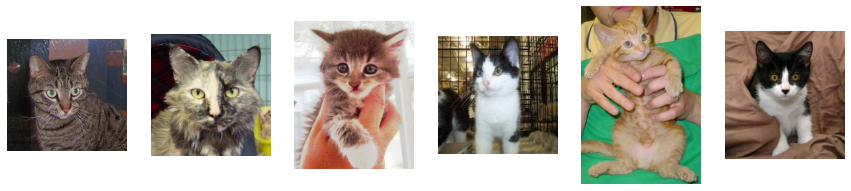

Dogs


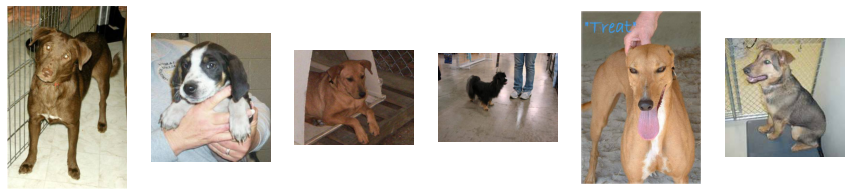

In [6]:
# Preview first few images
preview_cats = ["/cat.1.jpg", "/cat.10.jpg", "/cat.100.jpg", "/cat.1000.jpg", "/cat.1001.jpg", "/cat.1002.jpg"]
preview_dogs = ["/dog.1.jpg", "/dog.10.jpg", "/dog.100.jpg", "/dog.1000.jpg", "/dog.1001.jpg", "/dog.1002.jpg"]

print('Cats')
plt.figure(figsize=(15,10))
for i in range(6):
    im_cat = load_img(train_dir_cats + preview_cats[i])
    plt.subplot(1, 6, i+1)
    plt.imshow(im_cat)
    plt.axis('off')
plt.show()

print('Dogs')
plt.figure(figsize=(15,10))
for i in range(6):
    im_dog = load_img(train_dir_dogs + preview_dogs[i])
    ax = plt.subplot(1, 6, i+1)
    plt.imshow(im_dog)
    plt.axis('off')
plt.show()

**Config**

In [7]:
TARGET_SIZE = (224,224)
BATCH_SIZE = 32
EPOCHS = 50

**Data pipeline**

In [8]:
# Data generator (with data augmentation)
train_generator = ImageDataGenerator(rescale = 1./255, zoom_range = 0.2, rotation_range=10, horizontal_flip=True)
test_generator = ImageDataGenerator(rescale = 1./255)

# Data flow
training_data = train_generator.flow_from_directory(directory = train_dir,
                                                  target_size = TARGET_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  class_mode  = 'binary')
testing_data = test_generator.flow_from_directory(directory = test_dir,
                                                  target_size = TARGET_SIZE,
                                                  batch_size = BATCH_SIZE,
                                                  class_mode  = 'binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


**Transfer learning**

We will use a pre-trained VGG-16 model on the ImageNet dataset. This will save us several hours of training on a GPU. The model is exactly the same as we wrote above. We will change the last few layers however for a binary classification problem.

In [9]:
# Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

# Model architecture
base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [10]:
# Add final few dense layers
model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 21,203,778
Trainable params: 6,489,090
Non-trainable params: 14,714,688
_________________________________________________________________


**Train model**

In [11]:
history = model.fit_generator(training_data,
                        validation_data = testing_data,
                        epochs = EPOCHS,
                        verbose=True
                        )

2022-06-10 13:30:49.372979: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-06-10 13:30:51.770511: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


250/250 [==============================] - 201s 765ms/step - loss: 0.3446 - sparse_categorical_accuracy: 0.8579 - val_loss: 0.2034 - val_sparse_categorical_accuracy: 0.9190
Epoch 2/50
250/250 [==============================] - 121s 483ms/step - loss: 0.2155 - sparse_categorical_accuracy: 0.9115 - val_loss: 0.1816 - val_sparse_categorical_accuracy: 0.9260
Epoch 3/50
250/250 [==============================] - 120s 481ms/step - loss: 0.1915 - sparse_categorical_accuracy: 0.9215 - val_loss: 0.1790 - val_sparse_categorical_accuracy: 0.9315
Epoch 4/50
250/250 [==============================] - 120s 479ms/step - loss: 0.1650 - sparse_categorical_accuracy: 0.9319 - val_loss: 0.1675 - val_sparse_categorical_accuracy: 0.9305
Epoch 5/50
250/250 [==============================] - 122s 488ms/step - loss: 0.1538 - sparse_categorical_accuracy: 0.9390 - val_loss: 0.1817 - val_sparse_categorical_accuracy: 0.9265
Epoch 6/50
250/250 [==============================] - 121s 486ms/step - loss: 0.1450 - spar

**Learning curves**

Final accuracy on validation set: 0.9315000176429749


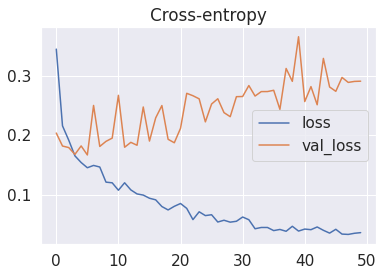

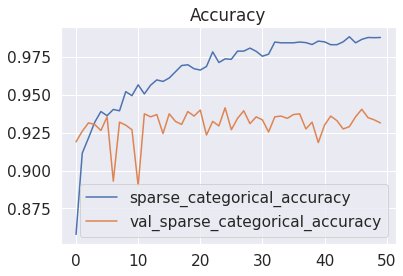

In [12]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(title="Accuracy")

print('Final accuracy on validation set:', history_df.loc[len(history_df)-1,'val_sparse_categorical_accuracy'])

**Test set predictions**

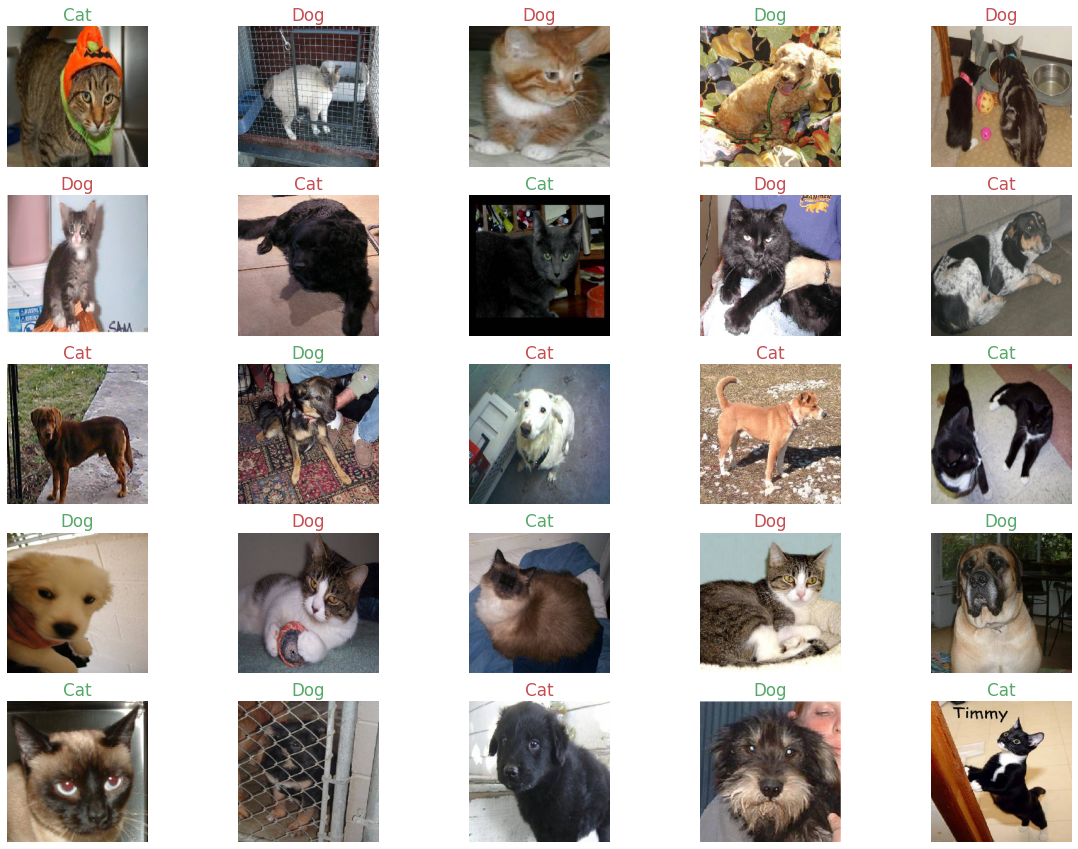

In [13]:
preds = model.predict(testing_data)
pred_classes = np.argmax(preds, axis=1)
class_names=['Cat', 'Dog']

plt.figure(figsize = (20,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(testing_data[0][0][i])
    if(pred_classes[i] == int(testing_data[0][1][i])):
        plt.title(class_names[pred_classes[i]], color='g')
    else:
        plt.title(class_names[pred_classes[i]], color='r')
    plt.axis('off')
plt.show()

Thanks for reading!